In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import optimizers, losses
from tensorflow.keras import Input, layers, Model

# import tensorflow_addons as tfa
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# tf.compat.v1.disable_eager_execution()
from jarvis.train import datasets, params
from jarvis.train.client import Client
from jarvis.utils.general import overload
from jarvis.utils.display import imshow
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#gpus.autoselect(1)

In [3]:
paths = datasets.download(name='xr/pna')
path = '{}/data/ymls/client-cls-512.yml'.format(paths['code'])
configs = {'batch': {'size': 4, 'fold': 0}}
client = Client(path, configs=configs)
gen_train, gen_valid = client.create_generators()
inputs = client.get_inputs(Input)

xs, ys = next(gen_train)
for k, v in xs.items():
    print("xs: {0} shape={1}".format(k, v.shape))
for k, v in ys.items():
    print("ys: {0} shape={1}".format(k, v.shape))



KeyError: 'valid'

In [3]:
# --- Define lambda functions
conv3 = lambda x, filters : layers.Conv3D(
    kernel_size=(1, 3, 3),
    filters=filters, 
    strides=1, 
    padding='same')(x)

conv1 = lambda x, filters : layers.Conv3D(
    kernel_size=(1, 1, 1),
    filters=filters, 
    strides=1,
    padding='same')(x)

pool = lambda x : layers.AveragePooling3D(
    pool_size=(1, 2, 2),
    strides=(1, 2, 2),
    padding='same')(x)

norm = lambda x : layers.BatchNormalization()(x)
relu = lambda x : layers.LeakyReLU()(x)

# --- Define concatenation
concat = lambda a, b : layers.Concatenate()([a, b])

# --- Define dense layer
dense = lambda x, k : conv3(relu(norm(x)), filters=k)
    
# --- Define bottleneck layer
bneck = lambda x, b : conv1(relu(norm(x)), filters=b)

def dense_block(x, k=8, n=3, b=1, verbose=False):
    """
    :params
    
      (tf Tensor) x : input into block
      (int)       k : growth factor
      (int)       n : number of convolutions in block
      (int)       b : bottleneck ratio (compress n * k concatenated feature maps to b * k)
      
    """
    ds_layer = None
    
    for i in range(n):
        
        # --- Concatenate all prior layers
        cc_layer = concat(cc_layer, ds_layer) if ds_layer is not None else x
            
        # --- Bottleneck if needed
        bn_layer = bneck(cc_layer, b * k) if i >= b else cc_layer
        
        # --- Perform dense operation
        ds_layer = dense(bn_layer, k)
        
        # --- Print
        if verbose:
            print('Creating layer {:02d}: cc_layer = {}'.format(i, cc_layer.shape))
            print('Creating layer {:02d}: bn_layer = {}'.format(i, bn_layer.shape))
            print('Creating layer {:02d}: ds_layer = {}'.format(i, ds_layer.shape))
    
    return concat(cc_layer, ds_layer)

In [4]:
# --- Create (smaller) Dense blocks
dense_block_ = lambda x : dense_block(x, k=32, n=3, b=1)

b0 = conv3(inputs['dat'], filters=32)
b1 = pool(dense_block_(b0))
b2 = pool(dense_block_(b1))

# --- Define transitional layer
trans = lambda x, b : pool(bneck(x, b))

# --- Create (larger) Dense blocks
dense_block_ = lambda x : dense_block(x, k=48, n=4, b=2)

b3 = trans(dense_block_(b2), 80)
b4 = trans(dense_block_(b3), 96)
b5 = trans(dense_block_(b4), 112)
b6 = dense_block_(b5)
b7 = bneck(b6, 112)
p1 = layers.GlobalAveragePooling3D()(b7)

logits = {}
logits['pna'] = layers.Dense(2, name='pna')(p1)
model = Model(inputs=inputs, outputs=logits)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dat (InputLayer)                [(None, 1, 512, 512, 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 1, 512, 512,  320         dat[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1, 512, 512,  128         conv3d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 1, 512, 512,  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
model.compile(optimizer=optimizers.Adam(learning_rate=2e-4),
    loss={'pna': losses.SparseCategoricalCrossentropy(from_logits=True)},
    metrics={'pna': 'accuracy'},
    experimental_run_tf_function=False)


In [6]:
client.load_data_in_memory()

[ 2021-06-08 19:57:04 ] [====================] 100.000% : Iterating | 001000    

In [7]:
model.fit(x=gen_train, 
    steps_per_epoch=1000, 
    epochs=12,
    validation_data=gen_valid,
    validation_steps=250,
    validation_freq=2
         )

Epoch 1/12
1000/1000 [==============================] - 476s 476ms/step - loss: 0.4928 - accuracy: 0.7700
Epoch 2/12
1000/1000 [==============================] - 501s 501ms/step - loss: 0.4195 - accuracy: 0.8165 - val_loss: 0.3341 - val_accuracy: 0.8620
Epoch 3/12
1000/1000 [==============================] - 462s 462ms/step - loss: 0.3808 - accuracy: 0.8382
Epoch 4/12
1000/1000 [==============================] - 500s 500ms/step - loss: 0.3459 - accuracy: 0.8485 - val_loss: 0.2548 - val_accuracy: 0.9150
Epoch 5/12
1000/1000 [==============================] - 462s 462ms/step - loss: 0.2816 - accuracy: 0.8842
Epoch 6/12
1000/1000 [==============================] - 500s 500ms/step - loss: 0.2457 - accuracy: 0.9043 - val_loss: 1.7685 - val_accuracy: 0.5570
Epoch 7/12
1000/1000 [==============================] - 462s 462ms/step - loss: 0.1902 - accuracy: 0.9247
Epoch 8/12
1000/1000 [==============================] - 499s 499ms/step - loss: 0.1572 - accuracy: 0.9377 - val_loss: 0.5628 - val_a

In [8]:
from skimage.transform import resize

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds['pna'])
            print(pred_index)
        class_channel = preds['pna'][:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2, 3))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = resize(jet_heatmap, (img.shape[1], img.shape[0]))
    superimposed_img = jet_heatmap * alpha + img
    return superimposed_img

In [9]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dat (InputLayer)                [(None, 1, 512, 512, 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 1, 512, 512,  320         dat[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1, 512, 512,  128         conv3d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 1, 512, 512,  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [59]:
xs, ys = next(gen_valid)
#lng = np.expand_dims(xs['msk'][0], axis=0)
img = np.expand_dims(xs['dat'][1], axis=0)
cls = ys['pna'][1]
print(type(img), img.shape)
print(ys['pna'])

<class 'numpy.ndarray'> (1, 1, 512, 512, 1)
[[1]
 [1]
 [0]
 [1]]


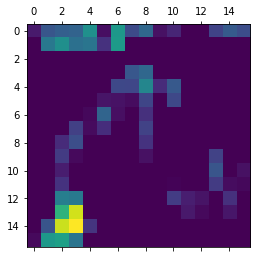

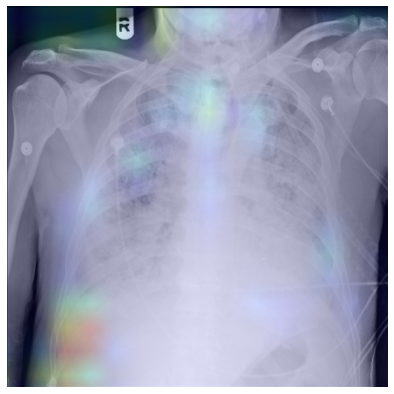

In [60]:
heatmap = make_gradcam_heatmap(img, model, 'conv3d_38', cls)
plt.matshow(heatmap)
plt.show()
img_ = img.reshape([512, 512, 1])
s_img = display_gradcam(img_, heatmap, 1)
imshow(s_img)